In [2]:
#Подключение библеотек
import pandas 
import matplotlib.pyplot as plt
import numpy
import sklearn 
from re import sub
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
# from imblearn.over_sampling import ADASYN
from sklearn.cluster import KMeans

In [3]:
#Чтение с JSON
dataframe = pandas.read_json("data.json")
dataframe

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [4]:
#Удаление колонки id
dataframe.drop(columns="id")

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...
39769,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,chinese,"[boneless chicken skinless thigh, minced garli..."


In [66]:
#Кол-во классов в датасете
class_label_len = len(dataframe["cuisine"].unique()) #подсчет классов 
print(class_label_len)

20


In [67]:
replace_ingridient = {
    "knorr": "",
    "sargento": "",
    "wishbone": "",
    "hiddenvalley": "",
    "kraft": "",
    'wasabe': 'wasabi',
    'sauc': 'sauce',
}

In [68]:
#Функция очистки датасета
def clear_dataframe(dataset: object):
    for i in range(len(dataset["ingredients"])):
        for j in range(len(dataset["ingredients"][i])): # Каждый ингридиент
            dataset["ingredients"][i][j] = sub("[^A-Za-z]", " " , dataset["ingredients"][i][j])#Оставляем все кроме букв
            dataset["ingredients"][i][j] = sub("[0-9]", " " , dataset["ingredients"][i][j])#Удаляем все цифры
            dataset["ingredients"][i][j] = dataset["ingredients"][i][j].lower()#Приводим к нижнему регистру
            for k, v in replace_ingridient.items():
                dataset["ingredients"][i][j].replace(k, v)#Убираем заменяем данные на основе списка(выше блок)
            dataset["ingredients"][i][j] = dataset["ingredients"][i][j].replace(' ', '')#
    return dataset

In [69]:
#Функция создания графиков
def graph(dataset: object):
    plt.figure(figsize = (20,50))
    plt.subplot(5, 1, 1)
    dataset["cuisine"].value_counts().plot.barh(color="g")
    
    plt.figure(figsize = (20,50))
    plt.subplot(5, 1, 2)
    pandas.Series(dict(Counter(','.join(j for i in dataframe["ingredients"] for j in i).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="g", title=f"Наибольшее кол-во ингредиентов в датасете")
    
    plt.figure(figsize = (20,50))
    plt.subplot(5, 1, 3)
    pandas.Series(dict(Counter(','.join(j for k in dataframe.loc[dataset["cuisine"] == "italian"]["ingredients"] for j in k).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="g", title=f"Наибольшее кол-во ингредиентов в датасете Италия")
    
    plt.figure(figsize = (20,50))
    plt.subplot(5, 1, 4)
    pandas.Series(dict(Counter(','.join(j for k in dataframe.loc[dataset["cuisine"] == "chinese"]["ingredients"] for j in k).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="g", title=f"Наибольшее кол-во ингредиентов в датасете Китай")
    
    plt.figure(figsize = (20,50))
    plt.subplot(5, 1, 5)
    pandas.Series(dict(Counter(','.join(j for k in dataframe.loc[dataset["cuisine"] == "russian"]["ingredients"] for j in k).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="g", title=f"Наибольшее кол-во ингредиентов в датасете Россия")
    
    # for i, name in enumerate(dataset["cuisine"].unique().sort_values()):
    #     plt.figure(figsize = (50,50))
    #     plt.subplot(5, 5, i+3)
    #     pandas.Series(dict(Counter(','.join(j for k in dataframe.loc[dataset.cuisine == name]["ingredients"] for j in k).split(',')))).sort_values(ascending=False).head(10).plot.bar(color="g", title=f"Наибольшее кол-во ингредиентов в {name}")


In [70]:
dataframe = clear_dataframe(dataframe)

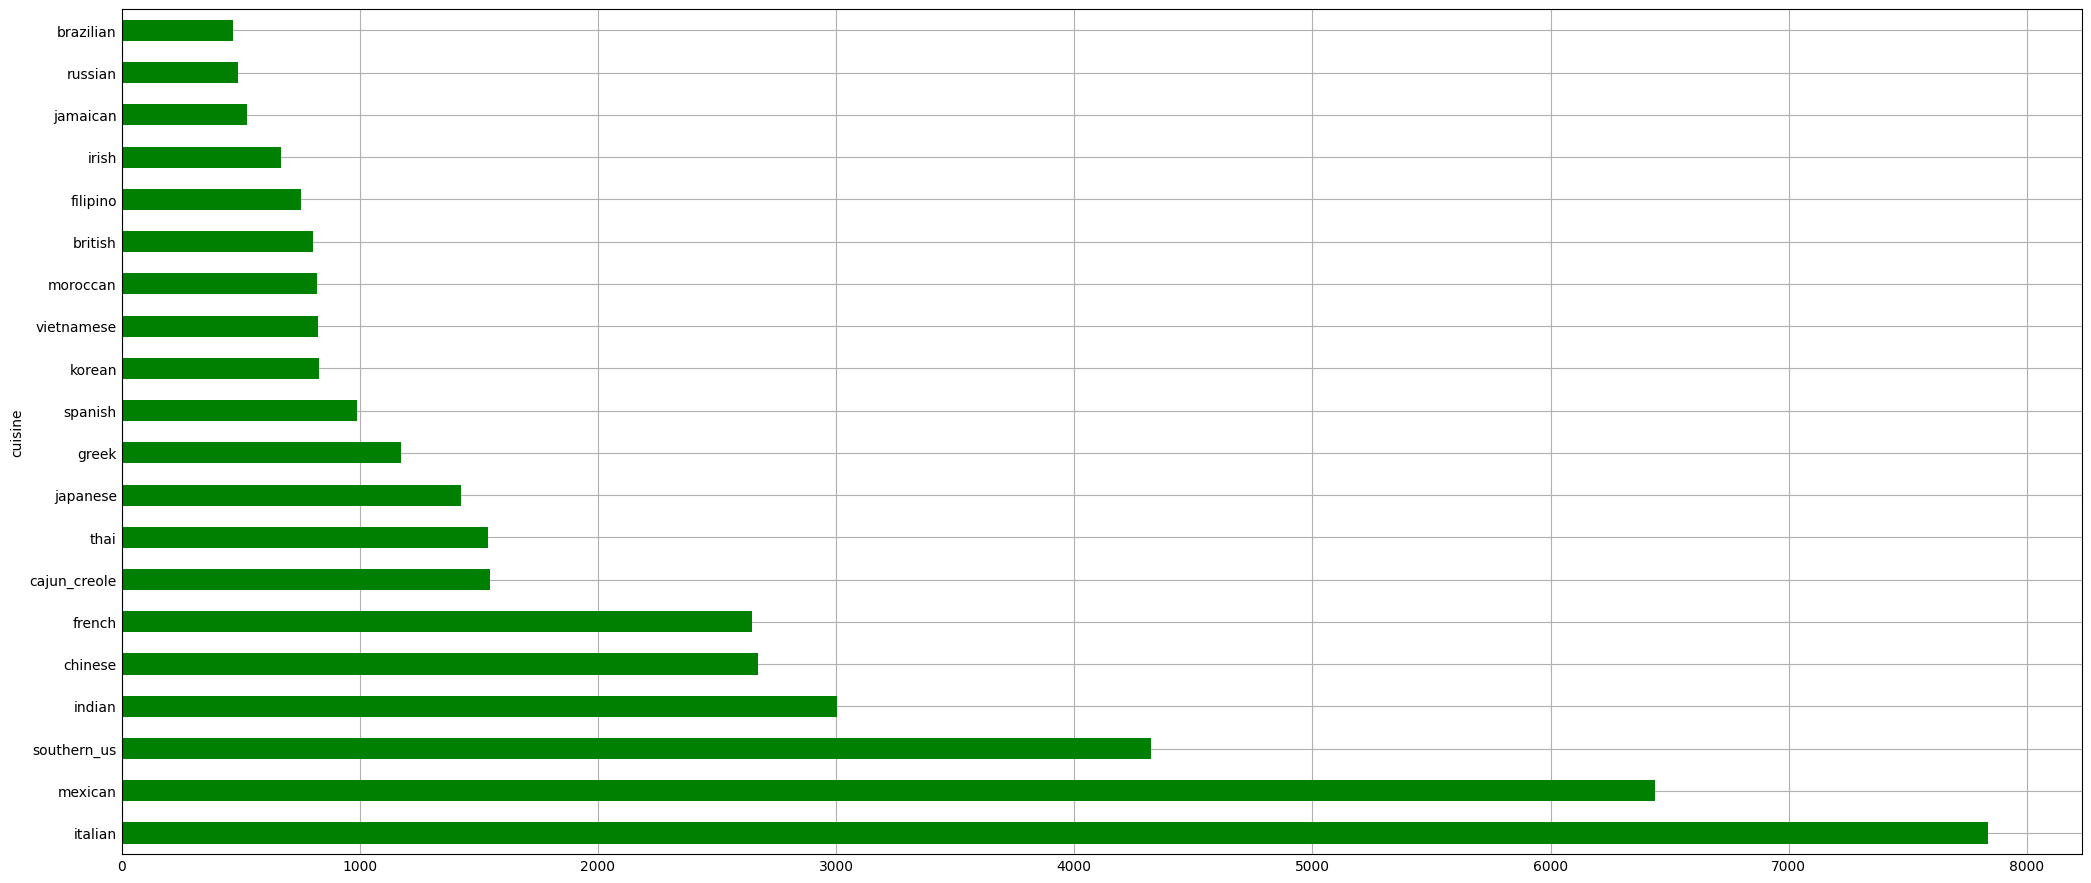

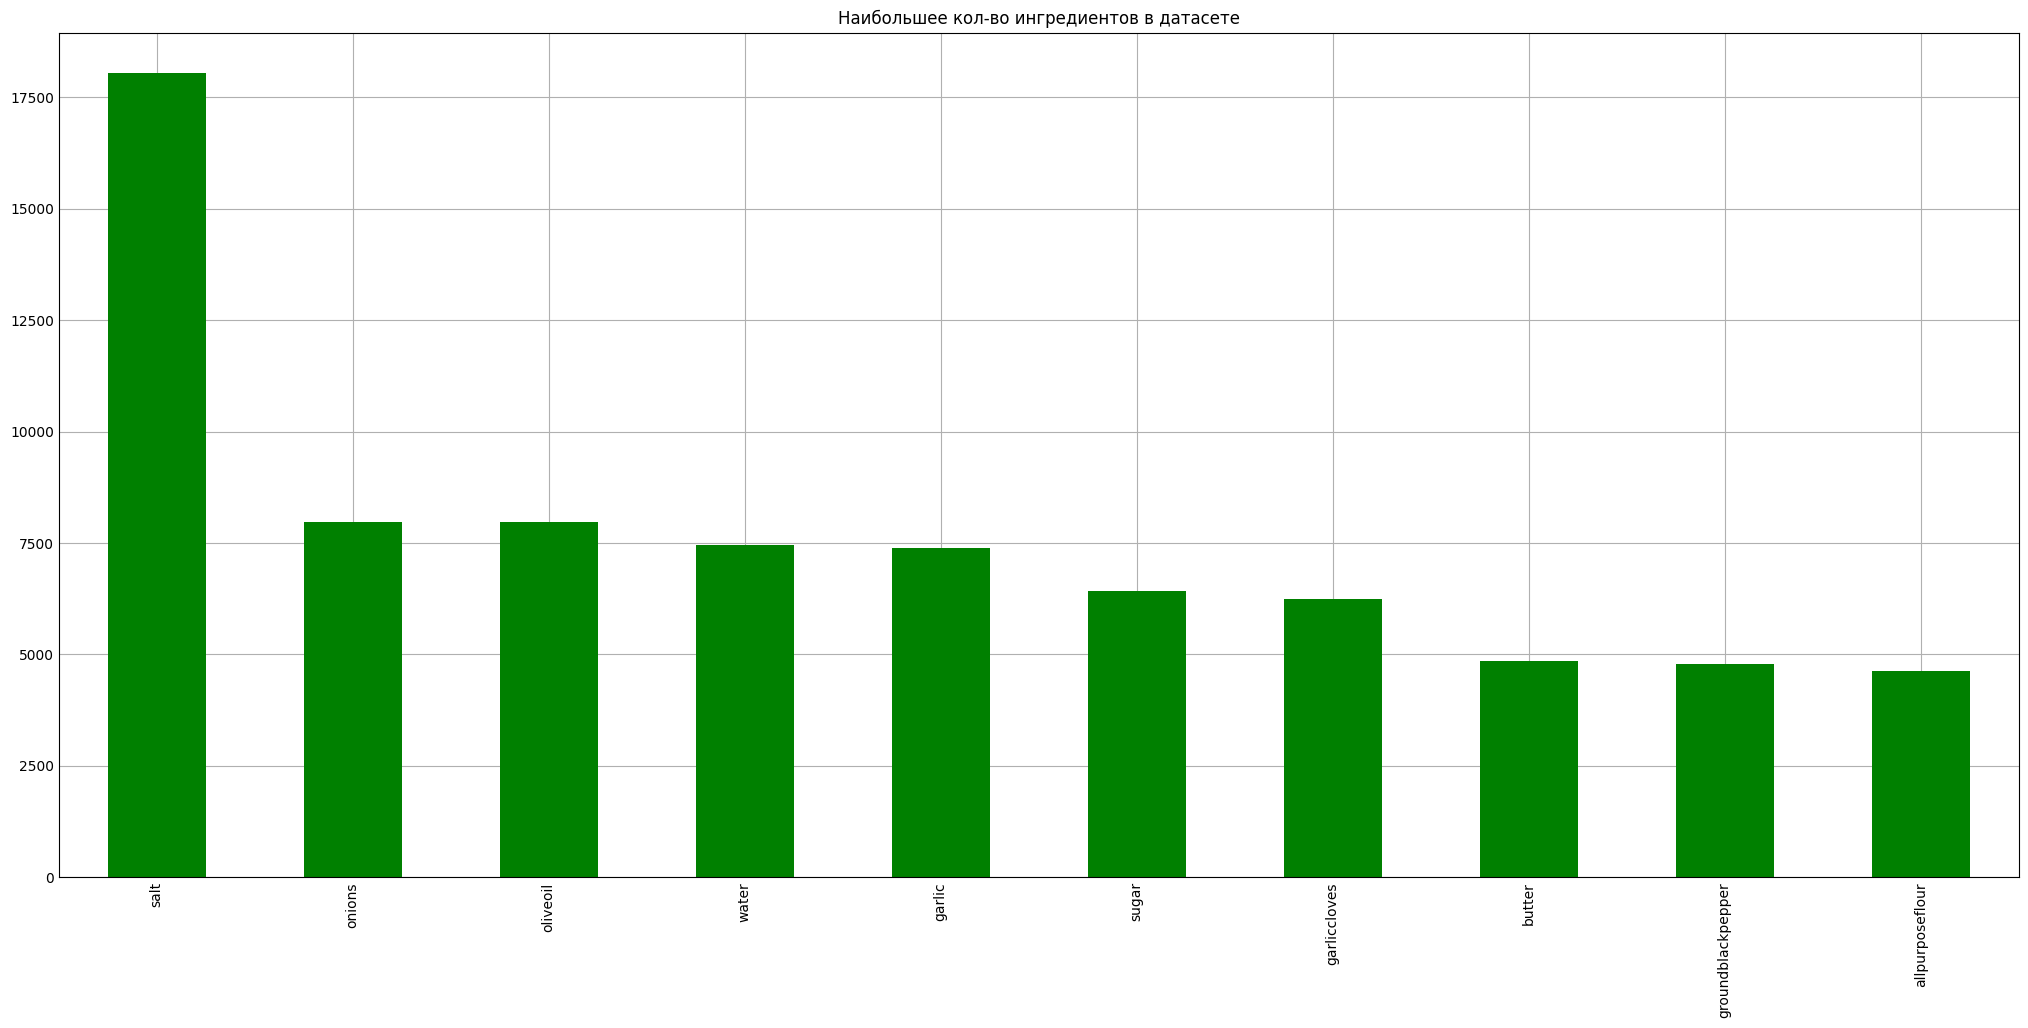

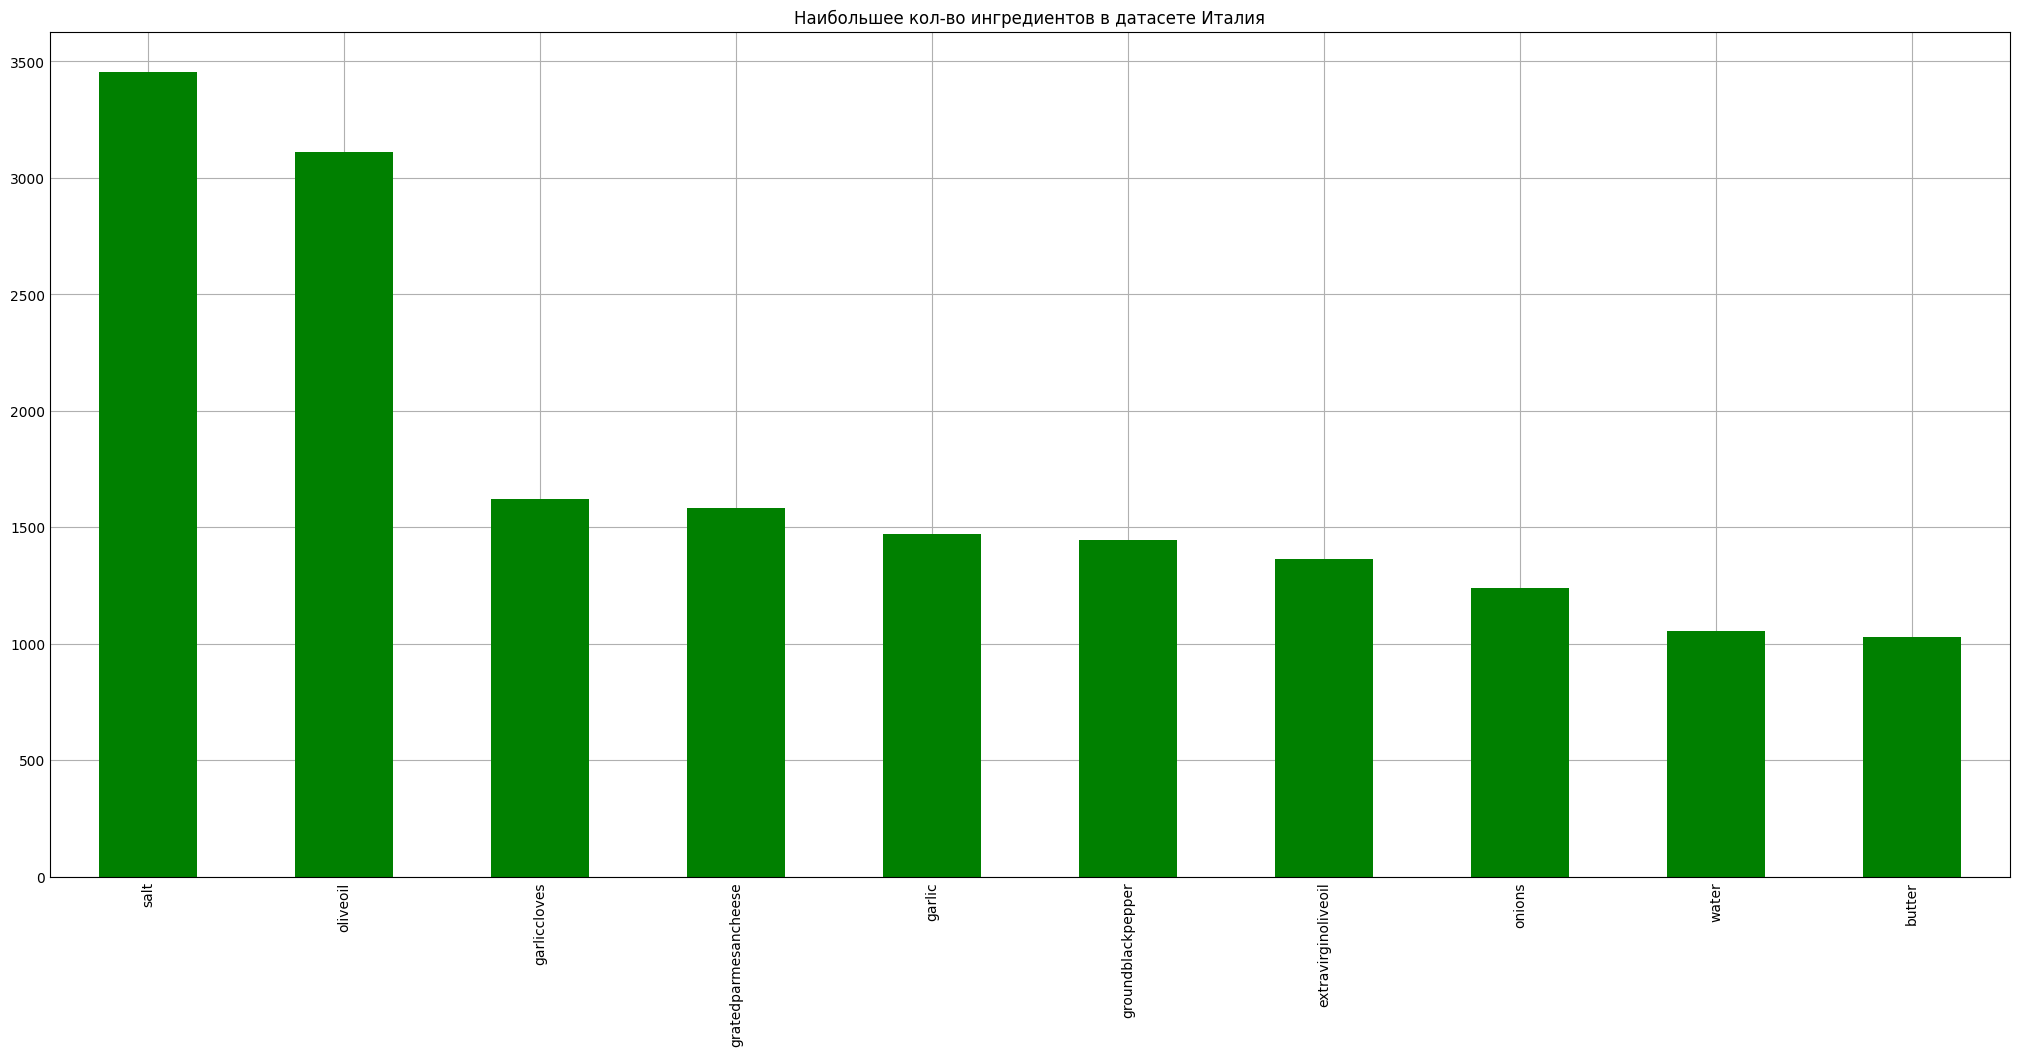

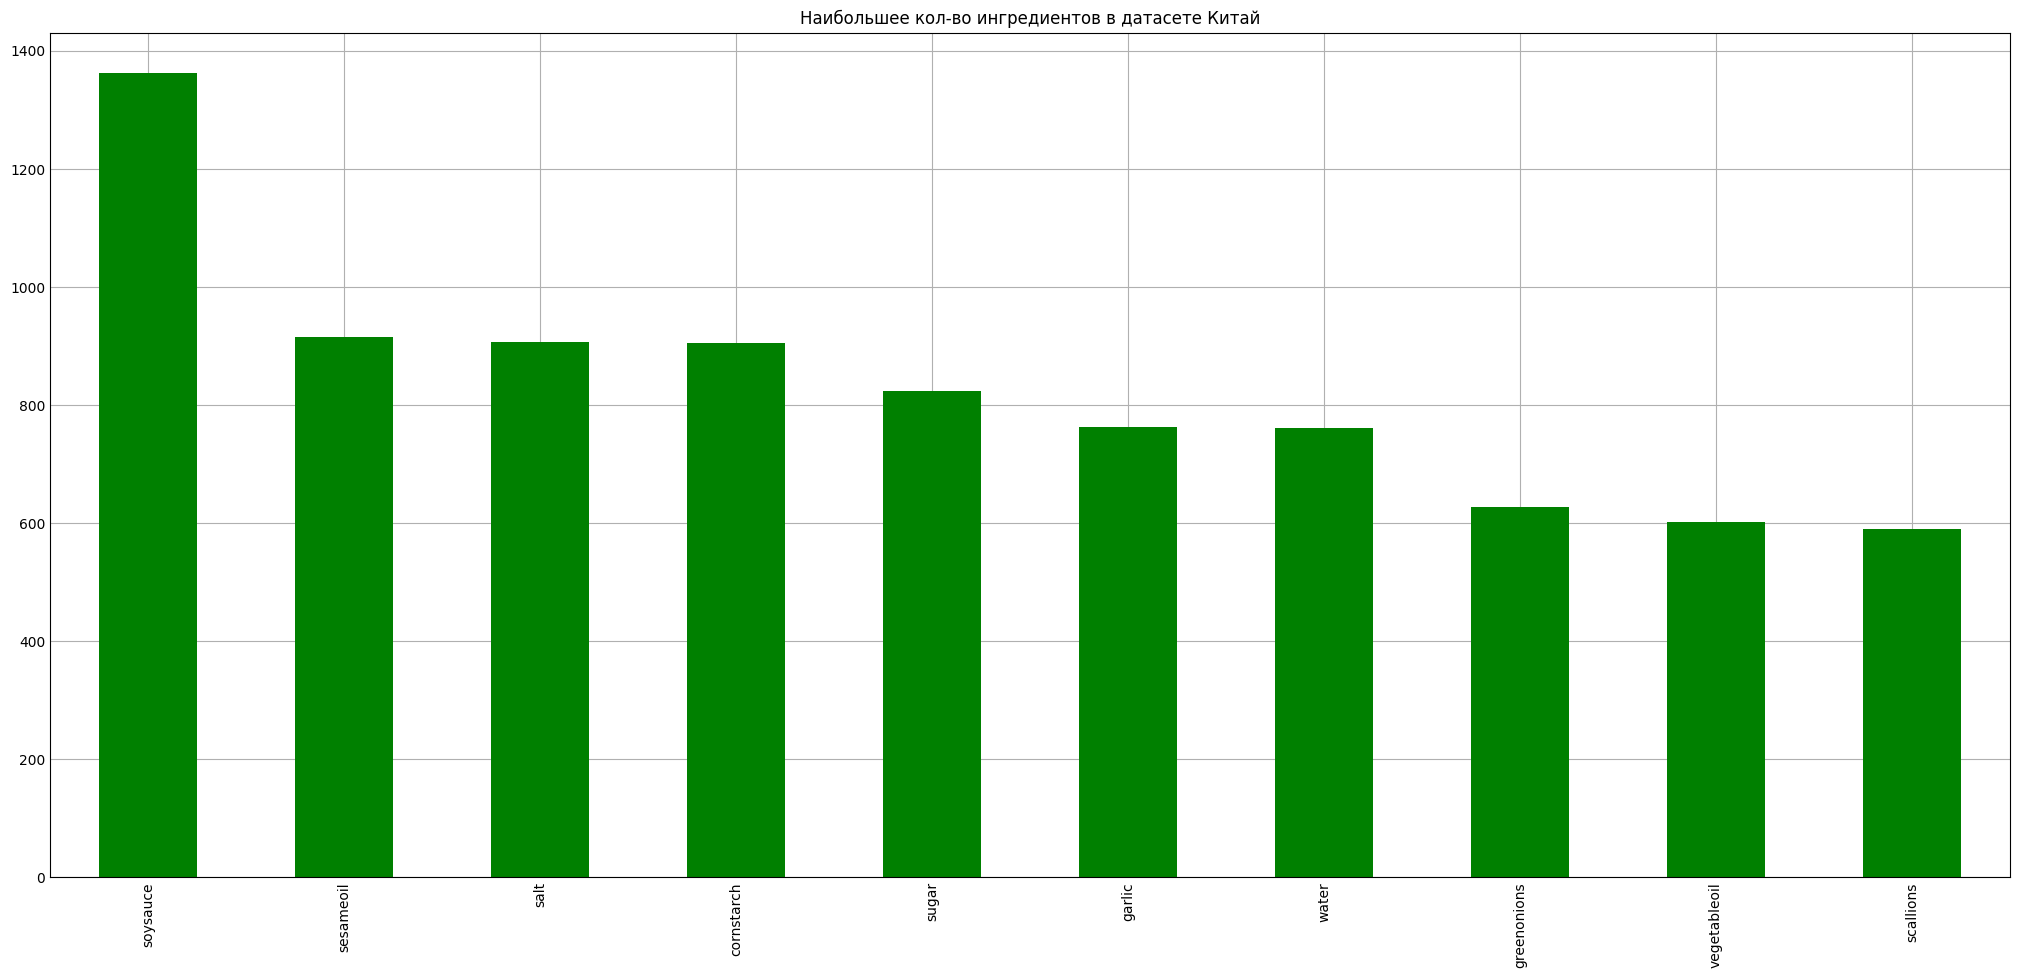

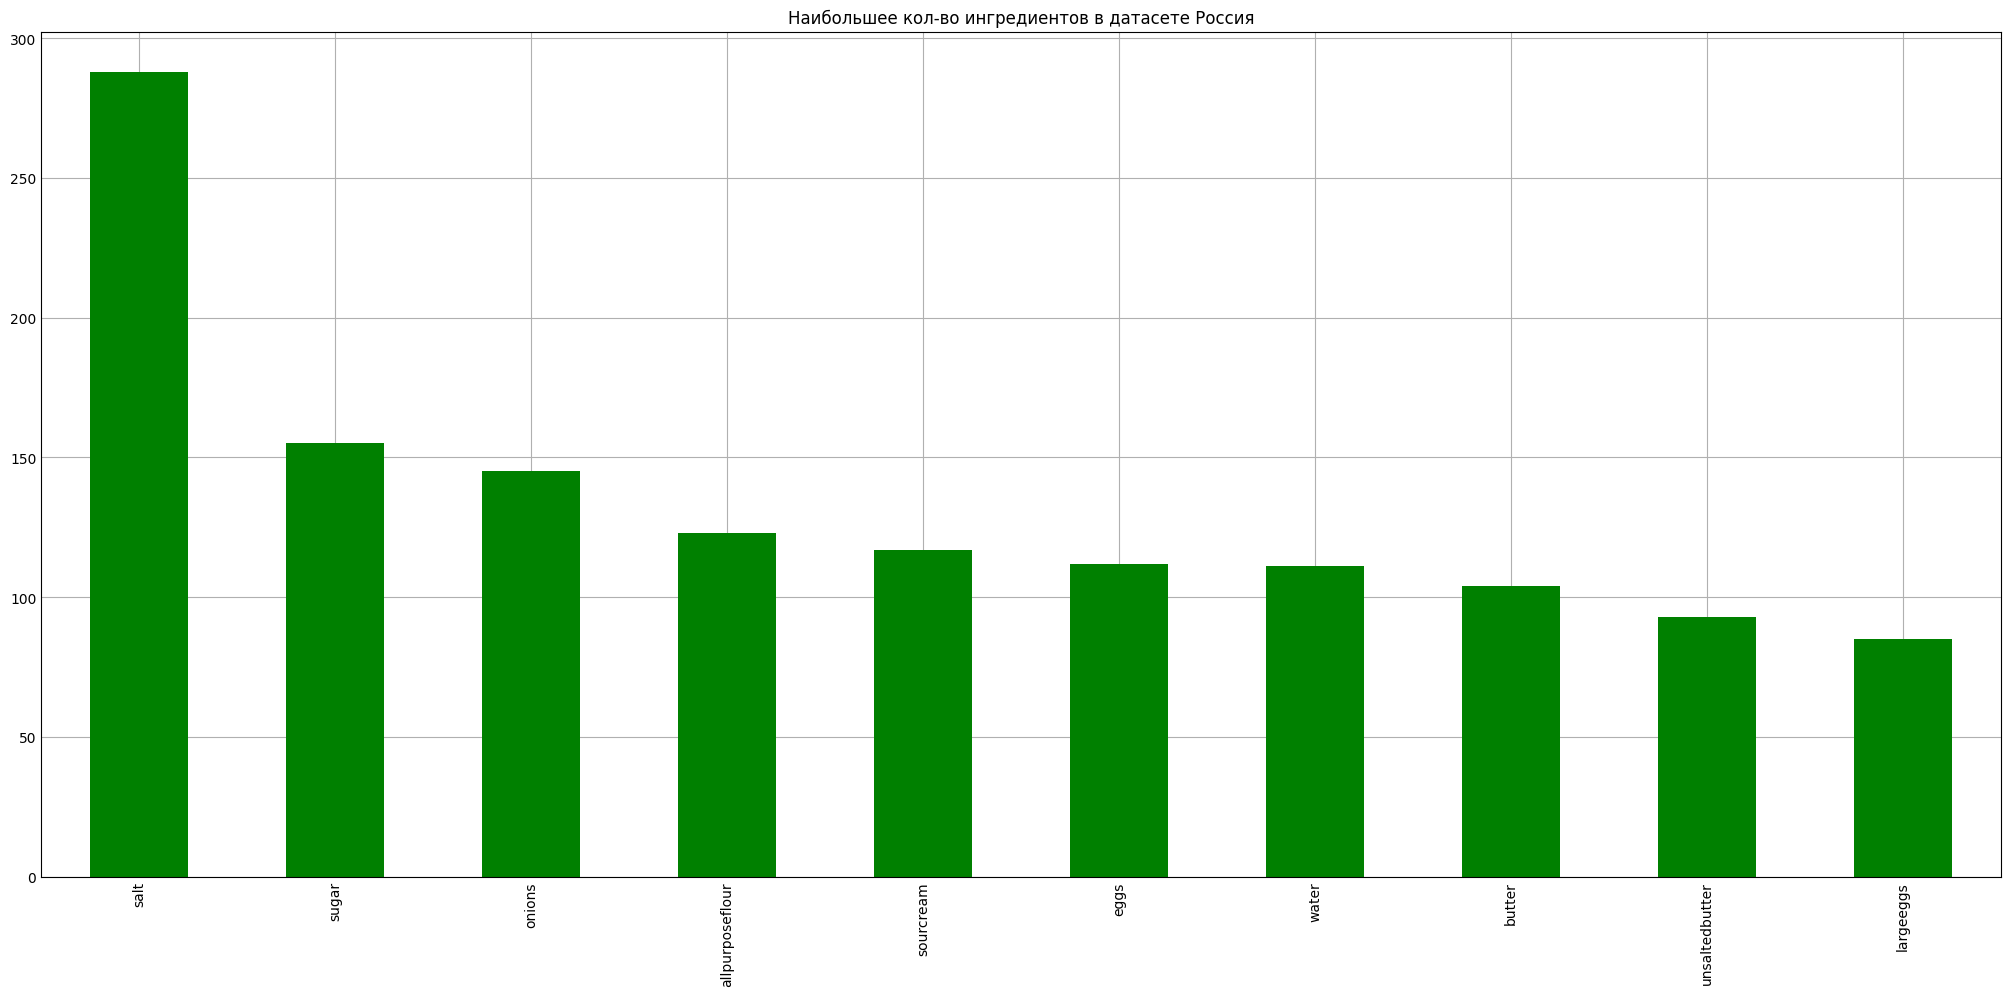

In [71]:
graph(dataframe)

In [72]:
#Словарь {Кухня: ID}
class_label = dataframe["cuisine"].unique() 
class_label = dict(zip(class_label,[i for i in range(class_label_len)])) 
print(class_label)

{'greek': 0, 'southern_us': 1, 'filipino': 2, 'indian': 3, 'jamaican': 4, 'spanish': 5, 'italian': 6, 'mexican': 7, 'chinese': 8, 'british': 9, 'thai': 10, 'vietnamese': 11, 'cajun_creole': 12, 'brazilian': 13, 'french': 14, 'japanese': 15, 'irish': 16, 'korean': 17, 'moroccan': 18, 'russian': 19}


In [73]:
#Заменяем кухню на id
dataframe["cuisine"] = dataframe["cuisine"].replace((class_label))
print(dataframe)

       cuisine                                        ingredients
0            0  [romainelettuce, blackolives, grapetomatoes, g...
1            1  [plainflour, groundpepper, salt, tomatoes, gro...
2            2  [eggs, pepper, salt, mayonaise, cookingoil, gr...
3            3                 [water, vegetableoil, wheat, salt]
4            3  [blackpepper, shallots, cornflour, cayennepepp...
...        ...                                                ...
39769       16  [lightbrownsugar, granulatedsugar, butter, war...
39770        6  [kraftzestyitaliandressing, purpleonion, brocc...
39771       16  [eggs, citrusfruit, raisins, sourdoughstarter,...
39772        8  [bonelesschickenskinlessthigh, mincedgarlic, s...
39773        7  [greenchile, jalapenochilies, onions, groundbl...

[39774 rows x 2 columns]


In [74]:
#Подсчет уникальных продуктов
b = []
for i, name in enumerate(dataframe["ingredients"]):
    for j, name1 in enumerate(dataframe["ingredients"][i]):
        b.append(name1)

all_unique_ingridients = pandas.unique(b)
print(all_unique_ingridients)

len_unique_ingridients = len(all_unique_ingridients)
print(len_unique_ingridients)

['romainelettuce' 'blackolives' 'grapetomatoes' ... 'lopchong'
 'tomatogarlicpastasauce' 'crushedcheesecrackers']
6642


C:\Users\Алексей\AppData\Local\Temp\ipykernel_3384\1048936914.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  all_unique_ingridients = pandas.unique(b)


In [75]:
#Горячее кодирование 
mlb = MultiLabelBinarizer()
dataframe1 = pandas.DataFrame(mlb.fit_transform(dataframe["ingredients"]),columns=mlb.classes_, index=dataframe.index)

In [76]:
#Добавление колонки с кухней
dataframe1.insert(0, "cuisine", dataframe["cuisine"])

In [77]:
#Разбивка на тренировочную и тестовую выборки
train, test, label_train, label_test = train_test_split(dataframe1.drop(columns="cuisine"), dataframe1["cuisine"], test_size=0.30, random_state=527)

In [78]:
train

,aai,aaipowder,abalone,abbamele,absinthe,aburaage,acaijuice,accent,accentseasoning,accompaniment,...,yuzukosho,zaatar,zatarainscreoleseasoning,zatarainsjambalayamix,zest,zestyitaliandressing,zinfandel,ziti,zucchini,zucchiniblossoms
24594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
#Логистическая регрессия
logisticRegr = LogisticRegression(random_state=54, max_iter=350)
logisticRegr.fit(train, label_train)
accuracy_logisticRegr = accuracy_score(label_test, logisticRegr.predict(test))
print(f"Точность:{round(accuracy_logisticRegr*100, 2)}%")

Точность:77.42%


In [81]:
#Случайный лес (проверяет все возможные разделения)
model_tree = RandomForestClassifier(n_estimators=200)
model_tree.fit(train, label_train)
accuracy_model_tree = accuracy_score(label_test, model_tree.predict(test))
print(f"Точность:{round(accuracy_model_tree*100, 2)}%")


Точность:71.11%


In [ ]:
#Метод k-средних(Он не подходит к классификации и метрика точность будет низкой)
kmeans = KMeans(n_clusters=20, random_state=123, n_init="auto")
kmeans.fit(train, label_train)
accuracy_model_kmeans = accuracy_score(label_test, kmeans.predict(test))
print(f"Точность:{round(accuracy_model_kmeans*100, 2)}%")

In [ ]:
#Метод k-ближайших соседей
neigh = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
neigh.fit(train, label_train)
accuracy_model_neigh = accuracy_score(label_test, neigh.predict(test))
print(f"Точность:{round(accuracy_model_neigh*100, 2)}%")

Точность: 30.65


In [ ]:
#Графики точности каждой модели
x = ["LR","RFC", "KM", "KNN"]
y = [accuracy_logisticRegr, accuracy_model_tree, accuracy_model_kmeans, neigh]
plt.figure(figsize=(5,5))
plt.bar(x, y,color ="g")